# Logistic Regression Model for Predicting Buy and Sell Points

Buying low and selling high is the basic tenet of trading equities. Being able to identify such points would enable a trader to outperform a stragegy of simply buying and holding. In other words, can we beat the market? 

### Imports

In [1]:
import pandas as pd
import numpy as np
import yahoo_fin
import yfinance as yf

In [2]:
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt
from yahoo_fin.stock_info import get_data, tickers_sp500, tickers_nasdaq, tickers_other, get_quote_table
import finta
from finta import TA

In [4]:
from scipy.signal import savgol_filter, argrelmin, argrelmax
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [5]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_union
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

In [6]:
from scipy.signal import argrelextrema
from scipy.signal import savgol_filter

In [7]:
ohlc = yf.download('mro', start='2015-05-05',end='2020-05-05')

[*********************100%***********************]  1 of 1 completed


In [8]:
ohlc = ohlc.reset_index()
ohlc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-05-05,31.290001,31.530001,29.930000,29.969999,27.537682,9686100
1,2015-05-06,30.379999,30.549999,29.520000,29.809999,27.390665,8453900
2,2015-05-07,29.820000,30.280001,28.469999,28.920000,26.572893,11315600
3,2015-05-08,29.410000,29.500000,28.750000,29.309999,26.931246,10442700
4,2015-05-11,29.330000,29.400000,28.340000,28.400000,26.095098,9064600


In [9]:
df=yf.download('mro',start='2015-05-05',end='2020-05-05')

[*********************100%***********************]  1 of 1 completed


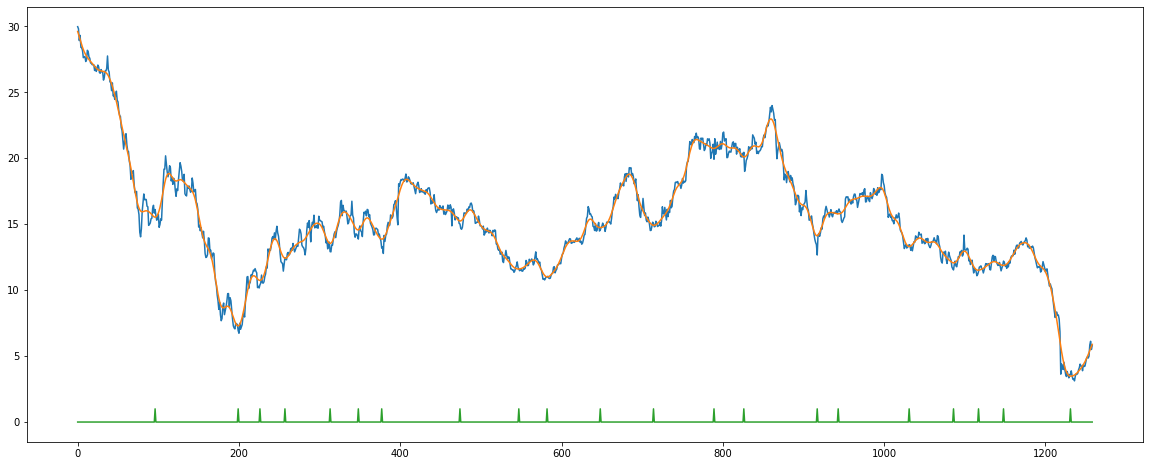

In [10]:
ohlc['Smooth'] = savgol_filter(ohlc.Close, 21, 2)
ohlc['Smooth'] = savgol_filter(ohlc.Smooth, 11, 2)
ohlc['Smooth'] = savgol_filter(ohlc.Smooth, 11, 1)

local_min = argrelextrema(ohlc.Smooth.values, np.less_equal, order=10)[0].tolist()

target = 'target'
ohlc[target] = 0
ohlc.loc[local_min, target] = 1

plt.figure(figsize=(20,8))
ohlc.Close.plot()
ohlc.Smooth.plot()
ohlc.target.plot()
plt.show()

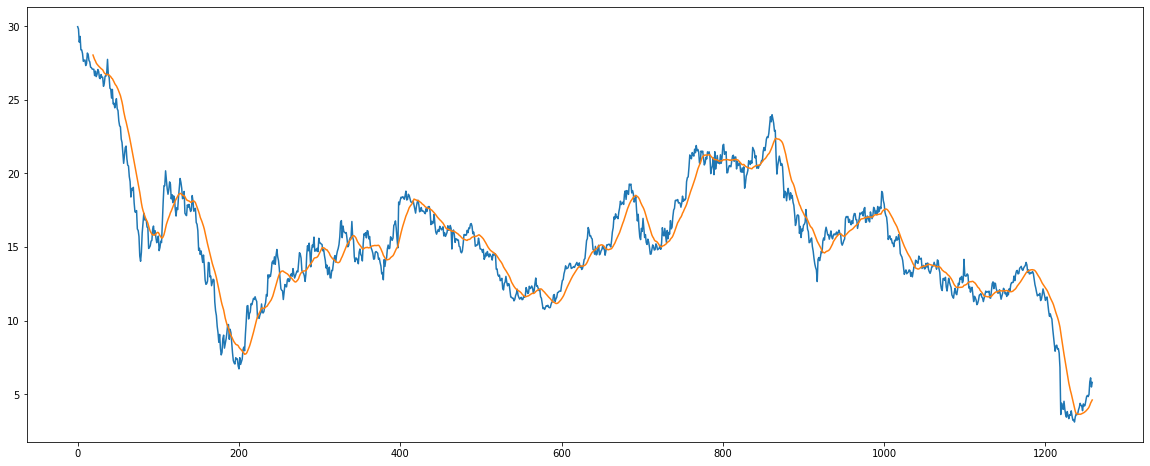

In [11]:
ohlc['MA20'] = ohlc.Close.rolling(20).mean()
ohlc['MA9'] = ohlc.Close.rolling(9).mean()
ohlc['MACD'] = ohlc['MA20'] - ohlc['MA9']

plt.figure(figsize=(20,8))
ohlc.Close.plot()
ohlc.MA20.plot()
# hist.MACD.plot()
plt.show()

In [12]:
ohlc.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Smooth,target,MA20,MA9,MACD
0,2015-05-05,31.290001,31.530001,29.930000,29.969999,27.537682,9686100,29.604437,0,NaN,NaN,NaN
1,2015-05-06,30.379999,30.549999,29.520000,29.809999,27.390665,8453900,29.402621,0,NaN,NaN,NaN
2,2015-05-07,29.820000,30.280001,28.469999,28.920000,26.572893,11315600,29.200806,0,NaN,NaN,NaN
3,2015-05-08,29.410000,29.500000,28.750000,29.309999,26.931246,10442700,28.998990,0,NaN,NaN,NaN
4,2015-05-11,29.330000,29.400000,28.340000,28.400000,26.095098,9064600,28.797174,0,NaN,NaN,NaN


In [13]:
def calc_slope(x):
    slope = np.polyfit(range(len(x)), x, 1)[0]
    return slope

def calc_acc(x):
    slope = np.polyfit(range(len(x)), x, 2)[0]
    return slope

ohlc['PctChange'] = ohlc.Close.pct_change()
ohlc['Slope'] = ohlc.Close.rolling(9).apply(calc_slope)
ohlc['Acc'] = ohlc.Close.rolling(11).apply(calc_slope)

ohlc.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Smooth,target,MA20,MA9,MACD,PctChange,Slope,Acc
0,2015-05-05,31.290001,31.530001,29.930000,29.969999,27.537682,9686100,29.604437,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-05-06,30.379999,30.549999,29.520000,29.809999,27.390665,8453900,29.402621,0,NaN,NaN,NaN,-0.005339,NaN,NaN
2,2015-05-07,29.820000,30.280001,28.469999,28.920000,26.572893,11315600,29.200806,0,NaN,NaN,NaN,-0.029856,NaN,NaN
3,2015-05-08,29.410000,29.500000,28.750000,29.309999,26.931246,10442700,28.998990,0,NaN,NaN,NaN,0.013485,NaN,NaN
4,2015-05-11,29.330000,29.400000,28.340000,28.400000,26.095098,9064600,28.797174,0,NaN,NaN,NaN,-0.031047,NaN,NaN


In [14]:
df['open']=df['Open']
df['close']=df['Close']
df['high']=df['High']
df['low']=df['Low']
df.drop(columns=['Open','High','Low','Close'],inplace=True)
df

,Adj Close,Volume,open,close,high,low
Date,,,,,,
2015-05-05,27.537682,9686100,31.290001,29.969999,31.530001,29.930000
2015-05-06,27.390665,8453900,30.379999,29.809999,30.549999,29.520000
2015-05-07,26.572893,11315600,29.820000,28.920000,30.280001,28.469999
2015-05-08,26.931246,10442700,29.410000,29.309999,29.500000,28.750000
2015-05-11,26.095098,9064600,29.330000,28.400000,29.400000,28.340000
...,...,...,...,...,...,...
2020-04-28,4.990000,30201400,4.960000,4.990000,5.070000,4.800000
2020-04-29,5.850000,49212900,5.190000,5.850000,5.880000,5.180000
2020-04-30,6.120000,76939700,6.310000,6.120000,6.340000,5.750000


In [17]:
ohlc['RSI']=TA.RSI(df)

In [18]:
ohlc['RSI_70'] = 0
ohlc['RSI_30'] = 0

ohlc['RSI_70'].loc[ohlc['RSI'] >= 70] = 1
ohlc['RSI_30'].loc[ohlc['RSI'] <= 30] = 1
ohlc

C:\Users\mmsub\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Date,Open,High,Low,Close,Adj Close,Volume,Smooth,target,MA20,MA9,MACD,PctChange,Slope,Acc,RSI_70,RSI_30,RSI
0,2015-05-05,31.290001,31.530001,29.930000,29.969999,27.537682,9686100,29.604437,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1,2015-05-06,30.379999,30.549999,29.520000,29.809999,27.390665,8453900,29.402621,0,NaN,NaN,NaN,-0.005339,NaN,NaN,0,0,NaN
2,2015-05-07,29.820000,30.280001,28.469999,28.920000,26.572893,11315600,29.200806,0,NaN,NaN,NaN,-0.029856,NaN,NaN,0,0,NaN
3,2015-05-08,29.410000,29.500000,28.750000,29.309999,26.931246,10442700,28.998990,0,NaN,NaN,NaN,0.013485,NaN,NaN,0,0,NaN
4,2015-05-11,29.330000,29.400000,28.340000,28.400000,26.095098,9064600,28.797174,0,NaN,NaN,NaN,-0.031047,NaN,NaN,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2020-04-28,4.960000,5.070000,4.800000,4.990000,4.990000,30201400,5.268026,0,4.1300,4.536667,-0.406667,0.028866,0.132333,0.096364,0,0,NaN
1255,2020-04-29,5.190000,5.880000,5.180000,5.850000,5.850000,49212900,5.423406,0,4.2580,4.754444,-0.496444,0.172345,0.166000,0.145818,0,0,NaN
1256,2020-04-30,6.310000,6.340000,5.750000,6.120000,6.120000,76939700,5.578785,0,4.4080,4.951111,-0.543111,0.046154,0.223333,0.191909,0,0,NaN
1257,2020-05-01,5.890000,6.030000,5.460000,5.500000,5.500000,37538000,5.734165,0,4.5095,5.094444,-0.584944,-0.101307,0.198167,0.174091,0,0,NaN


In [20]:
ohlc['MACD']=TA.MACD(df)['MACD']
ohlc['SIGNAL']=TA.MACD(df)['SIGNAL']
ohlc

,Date,Open,High,Low,Close,Adj Close,Volume,Smooth,target,MA20,MA9,MACD,PctChange,Slope,Acc,RSI_70,RSI_30,RSI,SIGNAL
0,2015-05-05,31.290001,31.530001,29.930000,29.969999,27.537682,9686100,29.604437,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN
1,2015-05-06,30.379999,30.549999,29.520000,29.809999,27.390665,8453900,29.402621,0,NaN,NaN,NaN,-0.005339,NaN,NaN,0,0,NaN,NaN
2,2015-05-07,29.820000,30.280001,28.469999,28.920000,26.572893,11315600,29.200806,0,NaN,NaN,NaN,-0.029856,NaN,NaN,0,0,NaN,NaN
3,2015-05-08,29.410000,29.500000,28.750000,29.309999,26.931246,10442700,28.998990,0,NaN,NaN,NaN,0.013485,NaN,NaN,0,0,NaN,NaN
4,2015-05-11,29.330000,29.400000,28.340000,28.400000,26.095098,9064600,28.797174,0,NaN,NaN,NaN,-0.031047,NaN,NaN,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2020-04-28,4.960000,5.070000,4.800000,4.990000,4.990000,30201400,5.268026,0,4.1300,4.536667,NaN,0.028866,0.132333,0.096364,0,0,NaN,NaN
1255,2020-04-29,5.190000,5.880000,5.180000,5.850000,5.850000,49212900,5.423406,0,4.2580,4.754444,NaN,0.172345,0.166000,0.145818,0,0,NaN,NaN
1256,2020-04-30,6.310000,6.340000,5.750000,6.120000,6.120000,76939700,5.578785,0,4.4080,4.951111,NaN,0.046154,0.223333,0.191909,0,0,NaN,NaN
1257,2020-05-01,5.890000,6.030000,5.460000,5.500000,5.500000,37538000,5.734165,0,4.5095,5.094444,NaN,-0.101307,0.198167,0.174091,0,0,NaN,NaN


In [21]:
local_max = argrelextrema(ohlc.Smooth.values, np.greater_equal, order=10)[0].tolist()
ohlc['target_sell'] = 0
ohlc.loc[local_max, 'target_sell'] = 1
ohlc

,Date,Open,High,Low,Close,Adj Close,Volume,Smooth,target,MA20,MA9,MACD,PctChange,Slope,Acc,RSI_70,RSI_30,RSI,SIGNAL,target_sell
0,2015-05-05,31.290001,31.530001,29.930000,29.969999,27.537682,9686100,29.604437,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,1
1,2015-05-06,30.379999,30.549999,29.520000,29.809999,27.390665,8453900,29.402621,0,NaN,NaN,NaN,-0.005339,NaN,NaN,0,0,NaN,NaN,0
2,2015-05-07,29.820000,30.280001,28.469999,28.920000,26.572893,11315600,29.200806,0,NaN,NaN,NaN,-0.029856,NaN,NaN,0,0,NaN,NaN,0
3,2015-05-08,29.410000,29.500000,28.750000,29.309999,26.931246,10442700,28.998990,0,NaN,NaN,NaN,0.013485,NaN,NaN,0,0,NaN,NaN,0
4,2015-05-11,29.330000,29.400000,28.340000,28.400000,26.095098,9064600,28.797174,0,NaN,NaN,NaN,-0.031047,NaN,NaN,0,0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2020-04-28,4.960000,5.070000,4.800000,4.990000,4.990000,30201400,5.268026,0,4.1300,4.536667,NaN,0.028866,0.132333,0.096364,0,0,NaN,NaN,0
1255,2020-04-29,5.190000,5.880000,5.180000,5.850000,5.850000,49212900,5.423406,0,4.2580,4.754444,NaN,0.172345,0.166000,0.145818,0,0,NaN,NaN,0
1256,2020-04-30,6.310000,6.340000,5.750000,6.120000,6.120000,76939700,5.578785,0,4.4080,4.951111,NaN,0.046154,0.223333,0.191909,0,0,NaN,NaN,0
1257,2020-05-01,5.890000,6.030000,5.460000,5.500000,5.500000,37538000,5.734165,0,4.5095,5.094444,NaN,-0.101307,0.198167,0.174091,0,0,NaN,NaN,0


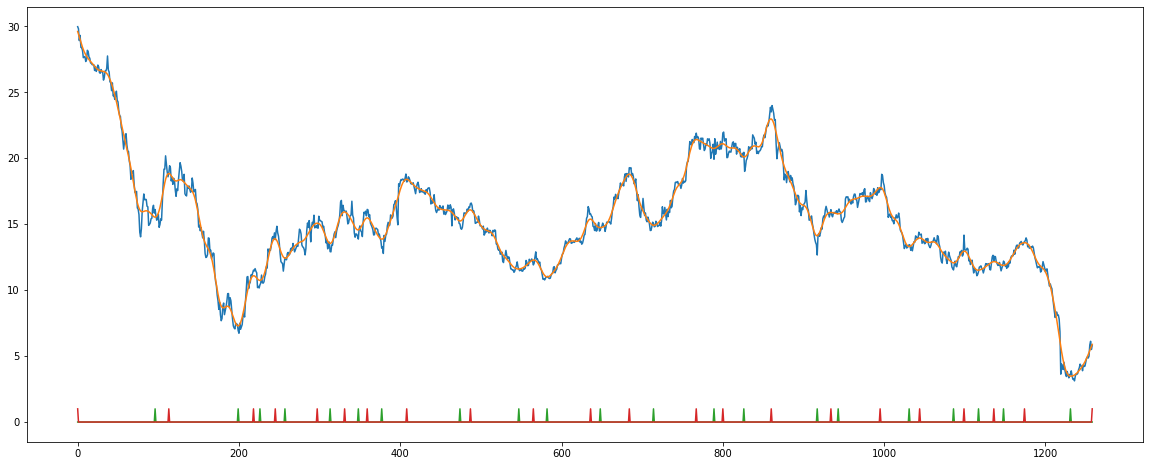

In [22]:
plt.figure(figsize=(20,8))
ohlc.Close.plot()
ohlc.Smooth.plot()
ohlc.target.plot()
ohlc.target_sell.plot()
plt.show()

In [23]:
ohlc.columns=ohlc.columns.str.lower()

In [24]:
ohlc.drop(columns='close',inplace=True)

In [25]:
df = df.reset_index()
df

,Date,Adj Close,Volume,open,close,high,low
0,2015-05-05,27.537682,9686100,31.290001,29.969999,31.530001,29.930000
1,2015-05-06,27.390665,8453900,30.379999,29.809999,30.549999,29.520000
2,2015-05-07,26.572893,11315600,29.820000,28.920000,30.280001,28.469999
3,2015-05-08,26.931246,10442700,29.410000,29.309999,29.500000,28.750000
4,2015-05-11,26.095098,9064600,29.330000,28.400000,29.400000,28.340000
...,...,...,...,...,...,...,...
1254,2020-04-28,4.990000,30201400,4.960000,4.990000,5.070000,4.800000
1255,2020-04-29,5.850000,49212900,5.190000,5.850000,5.880000,5.180000
1256,2020-04-30,6.120000,76939700,6.310000,6.120000,6.340000,5.750000
1257,2020-05-01,5.500000,37538000,5.890000,5.500000,6.030000,5.460000


In [26]:
ohlc['close']=df['close']

In [27]:
ohlc

,date,open,high,low,adj close,volume,smooth,target,ma20,ma9,macd,pctchange,slope,acc,rsi_70,rsi_30,rsi,signal,target_sell,close
0,2015-05-05,31.290001,31.530001,29.930000,27.537682,9686100,29.604437,0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,1,29.969999
1,2015-05-06,30.379999,30.549999,29.520000,27.390665,8453900,29.402621,0,NaN,NaN,NaN,-0.005339,NaN,NaN,0,0,NaN,NaN,0,29.809999
2,2015-05-07,29.820000,30.280001,28.469999,26.572893,11315600,29.200806,0,NaN,NaN,NaN,-0.029856,NaN,NaN,0,0,NaN,NaN,0,28.920000
3,2015-05-08,29.410000,29.500000,28.750000,26.931246,10442700,28.998990,0,NaN,NaN,NaN,0.013485,NaN,NaN,0,0,NaN,NaN,0,29.309999
4,2015-05-11,29.330000,29.400000,28.340000,26.095098,9064600,28.797174,0,NaN,NaN,NaN,-0.031047,NaN,NaN,0,0,NaN,NaN,0,28.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2020-04-28,4.960000,5.070000,4.800000,4.990000,30201400,5.268026,0,4.1300,4.536667,NaN,0.028866,0.132333,0.096364,0,0,NaN,NaN,0,4.990000
1255,2020-04-29,5.190000,5.880000,5.180000,5.850000,49212900,5.423406,0,4.2580,4.754444,NaN,0.172345,0.166000,0.145818,0,0,NaN,NaN,0,5.850000
1256,2020-04-30,6.310000,6.340000,5.750000,6.120000,76939700,5.578785,0,4.4080,4.951111,NaN,0.046154,0.223333,0.191909,0,0,NaN,NaN,0,6.120000
1257,2020-05-01,5.890000,6.030000,5.460000,5.500000,37538000,5.734165,0,4.5095,5.094444,NaN,-0.101307,0.198167,0.174091,0,0,NaN,NaN,0,5.500000


In [28]:
ohlc['cmf']=TA.CHAIKIN(ohlc)

In [29]:
ohlc['mfi']=TA.MFI(ohlc)

In [30]:
avg_vol=ohlc.volume.rolling(20).mean()
avg_vol

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
1254    54147115.0
1255    54325050.0
1256    55530905.0
1257    53084555.0
1258    51151855.0
Name: volume, Length: 1259, dtype: float64

In [31]:
ohlc['vol_spike']=0

volume_spike = ohlc['vol_spike'].loc[ohlc['volume'] >=2*avg_vol ] = 1

C:\Users\mmsub\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [32]:
ohlc.vol_spike.value_counts()

0    1231
1      28
Name: vol_spike, dtype: int64

In [34]:
from xam.feature_extraction import BayesianTargetEncoder, FeatureCombiner, CountEncoder
from xam.preprocessing import BayesianBlocksBinner, DistributionResampler, GroupbyTransformer
from xam.pipeline import ColumnSelector, LambdaTransfomer, SeriesTransformer, ToDataFrameTransformer

from sklearn.preprocessing import KBinsDiscretizer
from category_encoders import WOEEncoder, TargetEncoder
from sklearn.impute import SimpleImputer

from pygam import LogisticGAM, s, te

In [35]:
data = ohlc.dropna().copy()

used_cols = ['macd', 'pctchange', 'slope', 'acc','open','high','low','close','rsi','adj close','smooth','vol_spike',
            'ma20','ma9']
X, y = data[used_cols], data[target]

binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
encoder = WOEEncoder(used_cols)
clf = LogisticRegression(class_weight='balanced', random_state=42, C=10)

pipe = make_pipeline(binner, encoder, clf)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
scores.mean(), scores.std()

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

C:\Users\mmsub\Anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 11 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


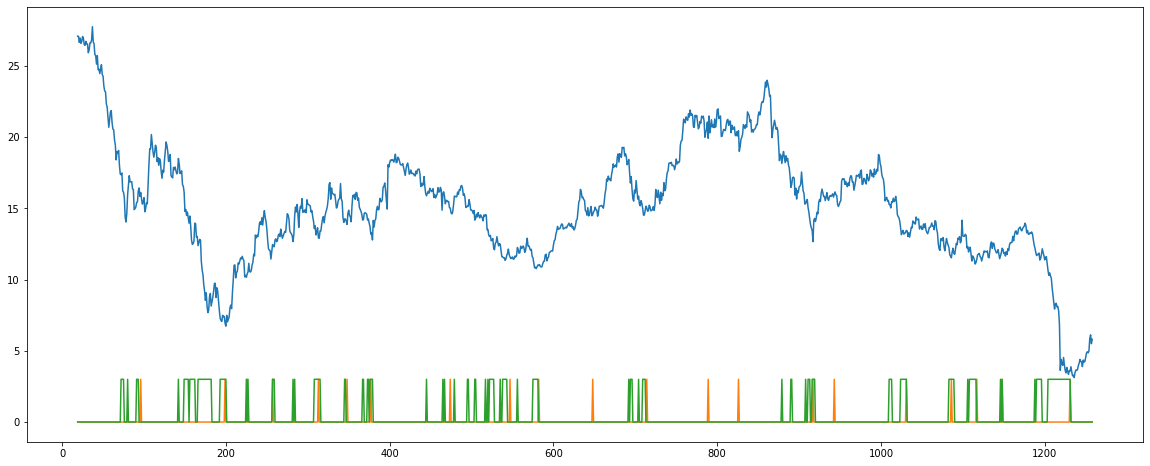

In [35]:
pred = (pipe.fit(X, y).predict_proba(X)[:,1] > 0.7).astype(np.int)

data['prediction'] = pred

factor = 3

plt.figure(figsize=(20,8))
data.close.plot()
(factor*data.target).plot()
(factor*data.prediction).plot()
plt.show()

In [36]:
data['prediction']

19      0
20      0
21      0
22      0
23      0
       ..
1254    0
1255    0
1256    0
1257    0
1258    0
Name: prediction, Length: 1240, dtype: int32

In [37]:
target_sell = 'target_sell'
# used_cols = ['macd', 'pctchange', 'slope', 'acc','open','high','low','close','rsi','adj close','smooth','vol_spike',
#             'ma20','ma9']
X_sell, y_sell = data[used_cols], data[target_sell]

# binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
# encoder = WOEEncoder(used_cols)
# clf = LogisticRegression(class_weight='balanced', random_state=42, C=10)

# pipe = make_pipeline(binner, encoder, clf)

scores_sell = cross_val_score(pipe, X_sell, y_sell, cv=5, scoring='roc_auc')
scores_sell.mean(), scores_sell.std()

C:\Users\mmsub\Anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 11 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\mmsub\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\mmsub\Anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 11 are 

(0.8490083822438104, 0.05997322587030541)

C:\Users\mmsub\Anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 11 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\mmsub\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


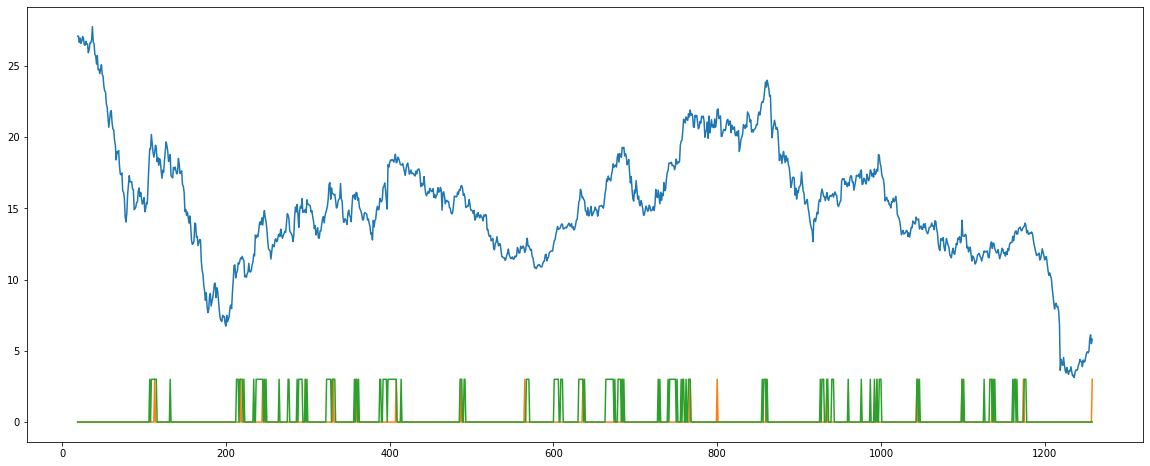

In [38]:
pred_sell = (pipe.fit(X_sell, y_sell).predict_proba(X_sell)[:,1] > 0.7).astype(np.int)

data['prediction_sell'] = pred_sell

factor = 3

plt.figure(figsize=(20,8))
data.close.plot()
(factor*data.target_sell).plot()
(factor*data.prediction_sell).plot()
plt.show()

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1240 entries, 19 to 1258
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1240 non-null   datetime64[ns]
 1   open             1240 non-null   float64       
 2   high             1240 non-null   float64       
 3   low              1240 non-null   float64       
 4   adj close        1240 non-null   float64       
 5   volume           1240 non-null   int64         
 6   smooth           1240 non-null   float64       
 7   target           1240 non-null   int64         
 8   ma20             1240 non-null   float64       
 9   ma9              1240 non-null   float64       
 10  macd             1240 non-null   float64       
 11  pctchange        1240 non-null   float64       
 12  slope            1240 non-null   float64       
 13  acc              1240 non-null   float64       
 14  rsi              1240 non-null   float6

In [42]:
data_index=data
data_index.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1240 entries, 19 to 1258
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1240 non-null   datetime64[ns]
 1   open             1240 non-null   float64       
 2   high             1240 non-null   float64       
 3   low              1240 non-null   float64       
 4   adj close        1240 non-null   float64       
 5   volume           1240 non-null   int64         
 6   smooth           1240 non-null   float64       
 7   target           1240 non-null   int64         
 8   ma20             1240 non-null   float64       
 9   ma9              1240 non-null   float64       
 10  macd             1240 non-null   float64       
 11  pctchange        1240 non-null   float64       
 12  slope            1240 non-null   float64       
 13  acc              1240 non-null   float64       
 14  rsi              1240 non-null   float6

In [44]:
data_index.index=data_index.date
data_index

,date,open,high,low,adj close,volume,smooth,target,ma20,ma9,...,rsi_70,rsi_30,signal,target_sell,close,cmf,mfi,vol_spike,prediction,prediction_sell
date,,,,,,,,,,,,,,,,,,,,,
2015-06-02,2015-06-02,27.200001,27.320000,26.650000,25.072447,8556300,27.120583,0,28.0430,27.507778,...,0,1,-0.194607,0,27.080000,-3.501601e+06,28.825634,0,0,0
2015-06-03,2015-06-03,27.090000,27.389999,26.950001,25.072447,5053400,27.046796,0,27.8985,27.465556,...,0,1,-0.204739,0,27.080000,-4.047500e+06,35.425667,0,0,0
2015-06-04,2015-06-04,26.879999,27.030001,26.639999,24.674326,4377700,26.972691,0,27.7405,27.295556,...,0,1,-0.219071,0,26.650000,-5.233442e+06,36.725902,0,0,0
2015-06-05,2015-06-05,26.540001,27.309999,26.500000,24.952087,5321700,26.900436,0,27.6420,27.168889,...,0,0,-0.230589,0,26.950001,-5.229718e+06,43.188473,0,0,0
2015-06-08,2015-06-08,26.790001,27.010000,26.440001,24.609516,4697500,26.832922,0,27.5055,27.046667,...,0,1,-0.244305,0,26.580000,-5.664279e+06,44.084503,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-28,2020-04-28,4.960000,5.070000,4.800000,4.990000,30201400,5.268026,0,4.1300,4.536667,...,1,0,-0.304270,0,4.990000,-2.961521e+07,64.170048,0,0,0
2020-04-29,2020-04-29,5.190000,5.880000,5.180000,5.850000,49212900,5.423406,0,4.2580,4.754444,...,1,0,-0.232833,0,5.850000,-1.608419e+07,64.687917,0,0,0
2020-04-30,2020-04-30,6.310000,6.340000,5.750000,6.120000,76939700,5.578785,0,4.4080,4.951111,...,1,0,-0.154218,0,6.120000,-9.157119e+06,65.231297,0,0,0


In [45]:
data_index.drop(columns='date',inplace=True)

In [48]:
def predic(df, target, target_sell):    
    # Splitting out data to feed into the model
    target_cols = [c for c in df.columns.tolist() if c not in [target]]
    X_target, y_target = df[target_cols].values, df.target.values
    X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(X_target, y_target, train_size=0.8, random_state=42)
    target_logreg = LogisticRegression(class_weight='balanced', max_iter=200, random_state=42, penalty = 'l2', solver='lbfgs', C=5.0)
    
    # Basic logreg
    target_logreg.fit(X_train_low, y_train_low)
    target_pred = target_logreg.predict(X_test_low)
    target_predictions = target_logreg.predict(X_target)
    
    # Adding our predictions to the data frame
    df['low_logreg_predictions'] = target_predictions
    
    # Splitting data for our max model
    max_cols = [c for c in df.columns.tolist() if c not in [target_sell]]
    X_max, y_max = df[max_cols].values, df.target_sell.values
    X_train, X_test, y_train, y_test = train_test_split(X_max, y_max, train_size=0.8, random_state=42)
    max_logreg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=350, penalty='l2', solver = 'lbfgs', C=5.0)
    
    # Basic log reg for max
    max_logreg.fit(X_train, y_train)
    max_pred = max_logreg.predict(X_test)
    max_predictions = max_logreg.predict(X_max)
    
    # Adding predictions for max back to data frame
    df['max_predictions'] = max_predictions
    
    return target_pred, y_test_low, max_pred, y_test,df

In [ ]:
predic(df, 'target', 'target_sell')

In [52]:
data_index.drop(columns=['prediction','prediction_sell'], inplace=True)
data_index.head()

,open,high,low,adj close,volume,smooth,target,ma20,ma9,macd,...,rsi_70,rsi_30,signal,target_sell,close,cmf,mfi,vol_spike,low_logreg_predictions,max_predictions
date,,,,,,,,,,,,,,,,,,,,,
2015-06-02,27.200001,27.320000,26.650000,25.072447,8556300,27.120583,0,28.0430,27.507778,-0.238146,...,0,1,-0.194607,0,27.080000,-3.501601e+06,28.825634,0,0,1
2015-06-03,27.090000,27.389999,26.950001,25.072447,5053400,27.046796,0,27.8985,27.465556,-0.244797,...,0,1,-0.204739,0,27.080000,-4.047500e+06,35.425667,0,1,0
2015-06-04,26.879999,27.030001,26.639999,24.674326,4377700,26.972691,0,27.7405,27.295556,-0.275873,...,0,1,-0.219071,0,26.650000,-5.233442e+06,36.725902,0,1,0
2015-06-05,26.540001,27.309999,26.500000,24.952087,5321700,26.900436,0,27.6420,27.168889,-0.276321,...,0,0,-0.230589,0,26.950001,-5.229718e+06,43.188473,0,1,0
2015-06-08,26.790001,27.010000,26.440001,24.609516,4697500,26.832922,0,27.5055,27.046667,-0.298844,...,0,1,-0.244305,0,26.580000,-5.664279e+06,44.084503,0,1,0


In [53]:
data_index.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1240 entries, 2015-06-02 to 2020-05-04
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   open                    1240 non-null   float64
 1   high                    1240 non-null   float64
 2   low                     1240 non-null   float64
 3   adj close               1240 non-null   float64
 4   volume                  1240 non-null   int64  
 5   smooth                  1240 non-null   float64
 6   target                  1240 non-null   int64  
 7   ma20                    1240 non-null   float64
 8   ma9                     1240 non-null   float64
 9   macd                    1240 non-null   float64
 10  pctchange               1240 non-null   float64
 11  slope                   1240 non-null   float64
 12  acc                     1240 non-null   float64
 13  rsi                     1240 non-null   float64
 14  rsi_70                

In [61]:
print('Log Reg ROC-AUC Score for test data:', roc_auc_score(np.array(data_index['target']), 
                                                            np.array(data_index['low_logreg_predictions']))
print('Log Reg Accuracy score for test:', accuracy_score(np.array(data_index['target']), 
                                                            np.array(data_index['low_logreg_predictions'])))

print('\nLog Reg ROC-AUC Score for test data:', roc_auc_score(np.array(data_index['target_sell']), 
                                                            np.array(data_index['max_predictions'])))
print('Log Reg Accuracy score for test:', accuracy_score(np.array(data_index['target_sell']), 
                                                            np.array(data_index['max_predictions'])))

SyntaxError: invalid syntax (<ipython-input-61-fc2648712b78>, line 3)

In [63]:
data_index.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1240 entries, 2015-06-02 to 2020-05-04
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   open                    1240 non-null   float64
 1   high                    1240 non-null   float64
 2   low                     1240 non-null   float64
 3   adj close               1240 non-null   float64
 4   volume                  1240 non-null   int64  
 5   smooth                  1240 non-null   float64
 6   target                  1240 non-null   int64  
 7   ma20                    1240 non-null   float64
 8   ma9                     1240 non-null   float64
 9   macd                    1240 non-null   float64
 10  pctchange               1240 non-null   float64
 11  slope                   1240 non-null   float64
 12  acc                     1240 non-null   float64
 13  rsi                     1240 non-null   float64
 14  rsi_70                

In [60]:
print('\nLog Reg ROC-AUC Score for test data:', roc_auc_score(np.array(data['target_sell']), 
                                                            np.array(data['prediction_sell'])))
print('Log Reg Accuracy score for test:', accuracy_score(np.array(data['target_sell']), 
                                                            np.array(data['prediction_sell'])))

KeyError: 'prediction_sell'